# Co-factor swap

<!-- The balance of co-factors within the cells is important 
In the implementated pathway of progesterone nine NADP and one NAD molecules 
In order for the cell to produce one pregesterone molecule through the implementated pathway nine NADPH molecules and one NAD $^+$ molecules are needed. 
 -->



The balance of co-factors within a cell is important to obtain a high theoretical yield of a given product (King, Zachary A., and Adam M. Feist, 2014). The NADP(H) and NAD(H) co-factors are needed in order for a cell to produce progesterone through the implemented pathway. Therefore, by increasing the concentration of available NADP(H) and NAD(H) co-factors in the cell, it should be theoretically possible to increase the yield of progesterone. 
This can be done using the “CofactorSwapOptimization” algorithm where possible target reactions to swap co-factors can be found.
The obvious choice would be to increase available NAD(H) and NADP(H) on the cost of FAD(H2). However, no FADH2 in the cytosol is included in the model which makes this approach impossible. Therefore, we instead used the algorithm to increase the concentration of available NADP(H) on the cost of NAD(H). Since four NADPH and only one NAD(+) are used in the implemented pathway, this approach should also theoretically increase the yield of progesterone.

In the code the following was done:
- Model iMM904_progesterone was loaded
- The objective was set to maximize the production of progesterone
- The theoretical yield was set to production of progesterone divided by the optake of glucose
- The algorithm was run and the result was visualized

In [1]:
# Load libraries
import numpy as np
from cobra.io import read_sbml_model, write_sbml_model
from cobra.util import create_stoichiometric_matrix
from cobra import Reaction, Metabolite
from cobra.core.gene import GPR
from cameo.strain_design.heuristic.evolutionary_based import CofactorSwapOptimization
from cameo.strain_design.heuristic.evolutionary.optimization import CofactorSwapOptimization
from cameo.strain_design.heuristic.evolutionary.objective_functions import product_yield, biomass_product_coupled_yield
from cameo.util import TimeMachine
from cameo.flux_analysis.analysis import flux_variability_analysis as fva
from cameo import load_model
from matplotlib import pyplot as plt

In [2]:
# Loading model
infilename = 'models/iMM904_progesterone.xml'
print(f"Loading {infilename}")
model = load_model(infilename)

Loading models/iMM904_progesterone.xml


In [3]:
# Choose the reaction that produced progesterone as the objective.
objective_reaction = model.reactions.DM_progesterone_c
model.objective = objective_reaction
print(f'Objective set to maximize {objective_reaction.id}: {objective_reaction.reaction}')

Objective set to maximize DM_progesterone_c: progesterone_c --> 


In [4]:
# Setting the progesterone yield as the formation of progesterone divided by the optake of glucose
py = product_yield(model.reactions.DM_progesterone_c, model.exchanges.EX_glc__D_e)
py

In [5]:
# Running the CofactorSwapOptimization Algorithm
# Find reactions that all have the targeted co-factor pairs and add reactions that have the co-factors swapped.
swap = CofactorSwapOptimization(model=model, cofactor_id_swaps=(["nadp_c","nadph_c"],["nad_c","nadh_c"]),objective_function=py)
print(f'Co-factor swap optimization of the model {model.id} used to increase available {swap._metadata["swap_pairs"][0][0]} and {swap._metadata["swap_pairs"][0][1]} on the cost of {swap._metadata["swap_pairs"][1][0]} and {swap._metadata["swap_pairs"][1][1]}')
solution_1 = swap.run(max_size = 10)

Co-factor swap optimization of the model iMM904_progesterone used to increase available nadp_c and nadph_c on the cost of nad_c and nadh_c
Starting optimization at Mon, 28 Nov 2022 20:45:05


HBox()

Finished after 00:00:23


In [6]:
# Printing results
solution_1

,index,targets,fitness
0,0,"(GAPD,)",0.141892
1,3,"(ALCD2x_copy2,)",0.133758
2,4,"(ALCD2x_copy1,)",0.133758
3,5,"(C4STMO1, HMGCOAR)",0.133758
4,12,"(HMGCOAR, C3STKR1)",0.131250
5,13,"(HMGCOAR,)",0.128835
6,14,"(MDH,)",0.117978
7,15,"(R07498, C4STMO1)",0.112300
8,17,"(C4STMO2,)",0.110527
9,19,"(SQLS, C3STDH2)",0.108809


The reactions listed above can be used as targets for co-factor swapping to increase the theoretical yield of progesterone. The single reaction with the highest fitness is GAPD which corospond with finding by King, Zachary A. and Adam M. Feist. This gene was therefore investigated further: 

In [5]:
# Stats of the GAPD reaction
model.reactions.GAPD

Reaction identifier,GAPD
Name,Glyceraldehyde-3-phosphate dehydrogenase
Memory address,0x07ffe2392ef10
Stoichiometry,g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c Glyceraldehyde 3-phosphate + Nicotinamide adenine dinucleotide + Phosphate <=> 3-Phospho-D-glyceroyl phosphate + H+ + Nicotinamide adenine dinucleotide - reduced
GPR,YJL052W or YJR009C or YGR192C
Lower bound,-999999.0
Upper bound,999999.0


NAP(+) is converted into NADH in the GAPD reaction, however, by swapping the co-factor into NADP(H) it should be possible to get a higher concentration of available NADPH in the cell and thereby increasing the yield of progesterone. As seen above three genes in the model are able to make the GAPD reaction. Thus, to be able to make co-factor swapping these genes have to be knocked out and a NADP(+) dependent GAPD needs to be implemented in the model. This is done in the following code: 

In [6]:
# Loading model
infilename = 'models/iMM904_progesterone.xml'
print(f"Loading {infilename}")
model = load_model(infilename)

Loading models/iMM904_progesterone.xml


In [7]:
# Knock out of GAPD genes
KOs = ["YJL052W","YJR009C","YGR192C"]
model_coswap1 = model.copy()
model_coswap1.id = "iMM904_progesterone_coswap1"
print(f"Model {model_coswap1.id} were made as a copy of {model.id}")
print(f"For model {model_coswap1.id}:")
for KO in KOs:
    model_coswap1.genes.get_by_id(KO).knock_out()
    if model_coswap1.genes.get_by_id(KO).functional == False:
        print(f"{model_coswap1.genes.get_by_id(KO).name} were knocked out")

Model iMM904_progesterone_coswap1 were made as a copy of iMM904_progesterone
For model iMM904_progesterone_coswap1:
TDH1 were knocked out
TDH2 were knocked out
TDH3 were knocked out


In [8]:
# Adding NADP dependent GAPD reaction
def import_reactions(reaction_dict,infilename):
    for m, reactions in reaction_dict.items():
        print(f"For model {m.id}:")
        with open(infilename,"r") as infile:
            infile.readline()
            for line in infile:
                line = line.rstrip().split(",")
                if line[0] in reactions:
                    r = Reaction(line[0])
                    r.name = line[2]
                    if line[3] != "":
                        r.subsystem = line[3]
                    r.lower_bound = float(line[4])
                    r.upper_bound = float(line[5])
                    if line[1] != "":
                        r.gpr = GPR.from_string(line[1])
                    for i in range(int(len(line[6:])/2)):
                        metaboliteID = line[6+i*2]
                        if metaboliteID != "":
                            metaboliteID = m.metabolites.get_by_id(metaboliteID)
                            bin = float(line[7+i*2])
                            r.add_metabolites({metaboliteID:bin})
                    print(f'Adding reaction {r} | enzyme {r.gpr}')
                    m.add_reactions([r])

reaction_dict = {model_coswap1:("R01063")}
import_reactions(reaction_dict,"data/co-factor_swap_reactions.csv")

For model iMM904_progesterone_coswap1:
Adding reaction R01063: g3p_c + nadp_c + pi_c <=> 13dpg_c + h_c + nadph_c | enzyme GDP1


In [9]:
# Calculate maximum growth
models = [model,model_coswap1]
biomass = []
for i, m in enumerate(models):
    biomass.append(m.optimize().objective_value)
    print(f'{m.id} | Maximum growth: {round(biomass[i],3)} gDW/h')

iMM904_progesterone | Maximum growth: 0.288 gDW/h
iMM904_progesterone_coswap1 | Maximum growth: 0.294 gDW/h


In [10]:
# Calculate flux towards progesterone
pp = []
for i, m in enumerate(models):
    with m:
        objective_reaction = m.reactions.DM_progesterone_c
        m.objective = objective_reaction
        pp.append(m.optimize().objective_value)
    print(f'{m.id} | Maximum progesterone productivity: {round(pp[i],3)} mmol/gDW*h')

iMM904_progesterone | Maximum progesterone productivity: 0.167 mmol/gDW*h
iMM904_progesterone_coswap1 | Maximum progesterone productivity: 0.167 mmol/gDW*h


In [11]:
# Calculate procentage increase in µ
print(f"Procentage increase in maximum growth: {round((biomass[1]/biomass[0]-1)*100,2)}%")

Procentage increase in maximum growth: 2.04%


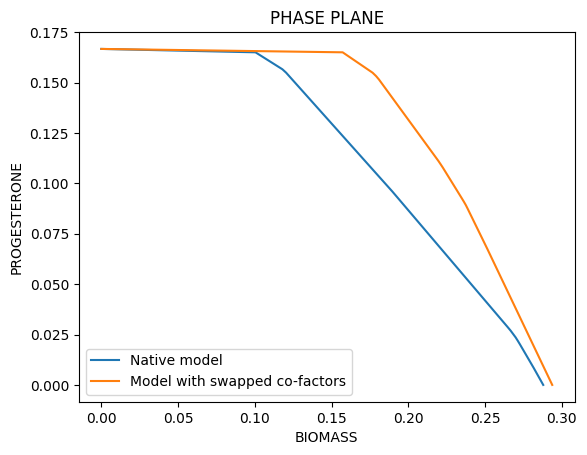

In [14]:
# Phase plane
for md in models:
    with md as m:
        m.objective = m.reactions.DM_progesterone_c
        m.optimize()
        max_prog = m.reactions.DM_progesterone_c.flux
        m.objective = m.reactions.BIOMASS_SC5_notrace
        len = 100
        pp = []
        biomass = []
        for i in range(len):
            pp.append((i/(len-1))*max_prog)
            m.reactions.DM_progesterone_c.lower_bound = pp[i]
            biomass.append(m.optimize().objective_value)
        plt.plot(biomass,pp)
plt.legend(["Native model","Model with swapped co-factors"])
plt.xlabel("BIOMASS")
plt.ylabel("PROGESTERONE")
plt.title("PHASE PLANE")
plt.savefig('figures/06_phase_plane.png',bbox_inches='tight')
plt.show()

From the results it is clear that the maximum flux towards progesterone does not change by the co-factor swapping, however, the growth rate does. Interestingly, the co-factor swapping have a major effect on the phase plane, such that a 60% higher growth rate can be obtained with maximum progesterone productivity.

In [ ]:
# Saving new model
outfilename = "models/"+model_coswap1.id+".xml"
print(f"Saving to {outfilename}")
write_sbml_model(model_coswap1, outfilename)

Saving to models/iMM904_progesterone_coswap1.xml


### References
King, Zachary A., and Adam M. Feist. "Optimal cofactor swapping can increase the theoretical yield for chemical production in Escherichia coli and Saccharomyces cerevisiae." Metabolic Engineering 24 (2014): 117-128.